# Overlapping Mixtures of Gaussian Processses

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import GPy
from GPclust import OMGP

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [3]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None]
Y = XY[:, 1, None]

 /Users/vale/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


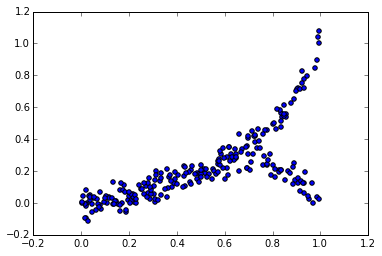

In [4]:
plt.scatter(X, Y);

We define a model assuming `K` = 2 trends. By default the model will be populated by `K` RBF kernels. The OMGP implementation is compatible with most kernels in GPy, so that you for example can encode periodicity in the model.

In [5]:
m = OMGP(X, Y, K=2, variance=0.01, prior_Z='DP')
m.log_likelihood()

array([[ 935.94878023]])

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

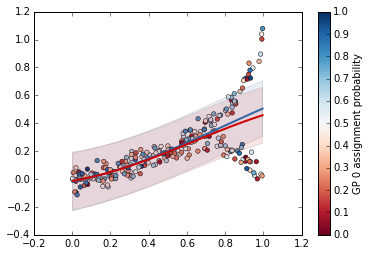

In [6]:
m.plot()

There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

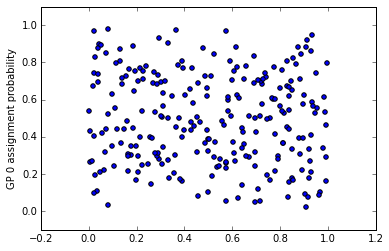

In [7]:
m.plot_probs(gp_num=0)

We can first performa a quick optimization to find the rough trends.

In [8]:
m.optimize(step_length=0.01, maxiter=20)

iteration 20 bound=[[ 1111.98562554]] grad=136.013950994, beta=0.659017979959 maxiter exceeded


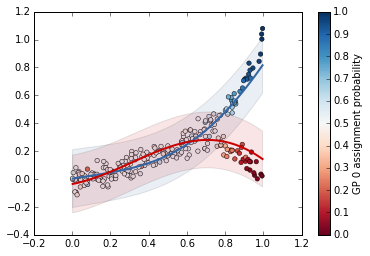

In [9]:
m.plot()

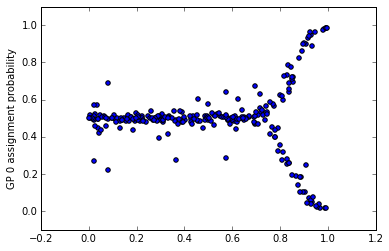

In [10]:
m.plot_probs()

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [11]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.01,+ve,,
rbf_1.variance,1.0,+ve,,
rbf_1.lengthscale,1.0,+ve,,
rbf.variance,1.0,+ve,,
rbf.lengthscale,1.0,+ve,,


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [12]:
m.optimize(step_length=0.01, maxiter=200)

iteration 50 bound=[[ 1125.85369254]] grad=0.000710344350336, beta=0.801153271827Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s21  04  -1.420601e+03   1.956927e+03 
    00s87  19  -1.423983e+03   1.993642e+03 
    01s00  22  -1.423983e+03   1.993642e+03 
Runtime:     01s00
Optimization status: Maximum number of f evaluations reached

iteration 100 bound=[[ 1490.68883156]] grad=0.00715508917798, beta=0.833060557206Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s59  12  -1.567219e+03   6.330107e+01 
    00s84  17  -1.567219e+03   6.330107e+01 
Runtime:     00s84
Optimization status: Converged

iteration 150 bound=[[ 1573.24503439]] grad=142.992652455, beta=0.0Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s13  02  -1.613985e+03   1.196725e+05 
    01s08  22  -1.587493e+03   1.072873e+01 
Runtime:     01s08
Optimization status: Converged

ite

 /Users/vale/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:IPython.utils.traitlets has moved to a top-level traitlets package.
 /Users/vale/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning:The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.


In [13]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.00146510228452,+ve,,
rbf_1.variance,1.15361120433,+ve,,
rbf_1.lengthscale,0.48539356331,+ve,,
rbf.variance,1.03920375916,+ve,,
rbf.lengthscale,0.545860307887,+ve,,


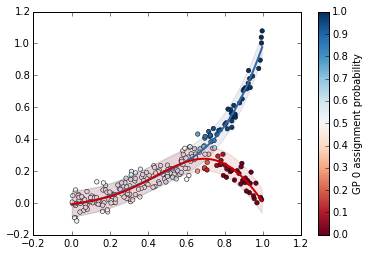

In [14]:
m.plot()

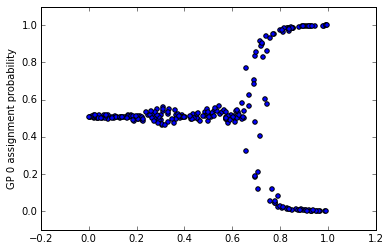

In [15]:
m.plot_probs()

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [16]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

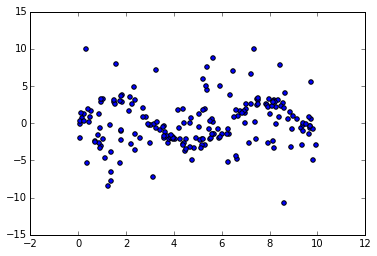

In [17]:
figsize(6, 4)
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [18]:
kernels = [GPy.kern.RBF(1)]
m = OMGP(x, y, K=1, prior_Z='DP', kernels=kernels)
m.variance = 3
m.hyperparam_interval = 100
m.rbf.lengthscale = 2

In [19]:
m.optimize(verbose=False)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s19  09   7.081719e+02   3.580422e+02 
    00s42  22   7.081718e+02   3.581942e+02 
Runtime:     00s42
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s09  04   7.081795e+02   3.429176e+02 
    00s28  13   7.081718e+02   3.581941e+02 
    00s43  22   7.081718e+02   3.581942e+02 
Runtime:     00s43
Optimization status: Maximum number of f evaluations reached



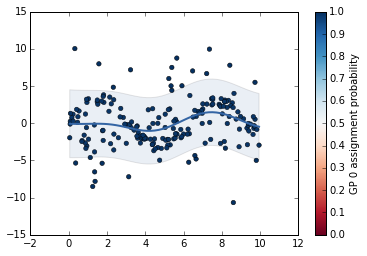

In [20]:
figsize(6, 4)
m.plot()

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [21]:
kernels = [GPy.kern.White(1, name='Noise'), GPy.kern.RBF(1, name='Signal')]
m = OMGP(x, y, K=2, prior_Z='DP', kernels=kernels)
m.variance = 3
m.hyperparam_interval = 250
m.Signal.lengthscale = 2

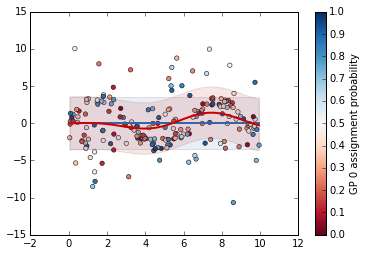

In [22]:
figsize(6, 4)
m.plot(0)

In [23]:
m.optimize(step_length=0.01, verbose=False)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s16  04   9.600238e+02   1.011062e+02 
    00s57  19   9.280463e+02   8.096961e-01 
    00s64  22   9.280463e+02   8.096961e-01 
Runtime:     00s64
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s15  04   8.181186e+02   3.601499e+01 
    00s29  09   8.181188e+02   7.719498e+01 
    00s58  22   8.181186e+02   7.724384e+01 
Runtime:     00s58
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s13  04   7.295633e+02   1.675095e+02 
    00s58  20   7.295431e+02   1.838057e+02 
    00s64  22   7.295431e+02   1.838057e+02 
Runtime:     00s64
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g| 

In [24]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.245794773178,+ve,,
Noise.variance,8.24580853631,+ve,,
Signal.variance,2.04683657589,+ve,,
Signal.lengthscale,1.21835900408,+ve,,


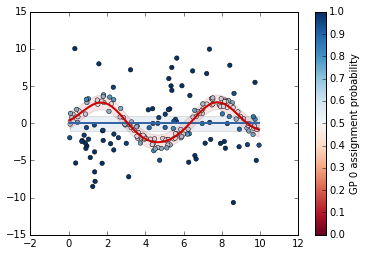

In [25]:
m.plot()

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the Noise GP, while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

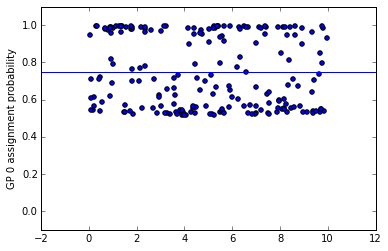

In [27]:
m.plot_probs(0)
plt.axhline(0.75);

In [28]:
thr = 0.75
idx = np.where(m.phi[:,0] < thr)[0]
nidx = np.where(m.phi[:,0] >= thr)[0]

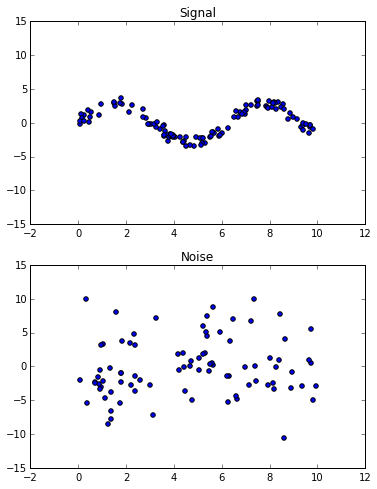

In [29]:
figsize(6, 8)
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');